## ABOUBAKAR Ouattara

## TP 2.3 : Profit et perte de la couverture Black-Scholes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Paramètres
T = 2           # Maturité
n = 1000        # Nombre de pas de temps
m = 1000        # Nombre de trajectoires
dt = T / n      # Pas de temps
lamda = 2       # Paramètre lambda
c = 0.4         # Valeur cible à long terme
gamma = 0.3     # Paramètre gamma
sig0 = 1        # Valeur initiale de sigma
S0 = 100        # prixx initial
r = 0.02        # taux d'interet


### Question 1

En utilisant la formule de Itô à $ \sigma_te^{\lambda t} $ On à: 

$$
\begin{align*}
    d \sigma_t e^{\lambda t} =& \lambda \sigma_t e^{\lambda t} \, dt + e^{\lambda t} \, d \sigma_t\\

    =& e^{\lambda t} \left[ \lambda \sigma_t \, dt + d \sigma_t \right]\\
    =& e^{\lambda t} \left[ \lambda c \, dt + \gamma \, dW_t^{(2)} \right]
\end{align*}
$$

On obtient donc

$$
\sigma_s = c + ( \sigma_0 - c) e^{-\lambda s} + \gamma \int_0^s e^{-\lambda (s- t)} \, dW^{(2)}_s
$$


In [3]:
def sigma(c, sig0, lamda, gamma, T, n, m = 1000):
    dt = T/n
    # Mouvement brownien
    dWt = np.zeros((n , m))
    dWt[1:] = np.sqrt(dt)*np.random.normal(0, 1, (n-1, m)) 

    # discretisation du temps
    times = np.linspace(0, T, n, endpoint=True)[:,None]
    
    # Calcul de l'integrale stochastique
    intergral = np.cumsum(np.exp(lamda*times)*dWt, axis=0)
    intergral = np.exp(-lamda*times)*intergral

    # application de la formule fermé de sigma_t trouver
    res = c + (sig0 - c)*np.exp(-lamda*times) + gamma*intergral
    return np.transpose(res)

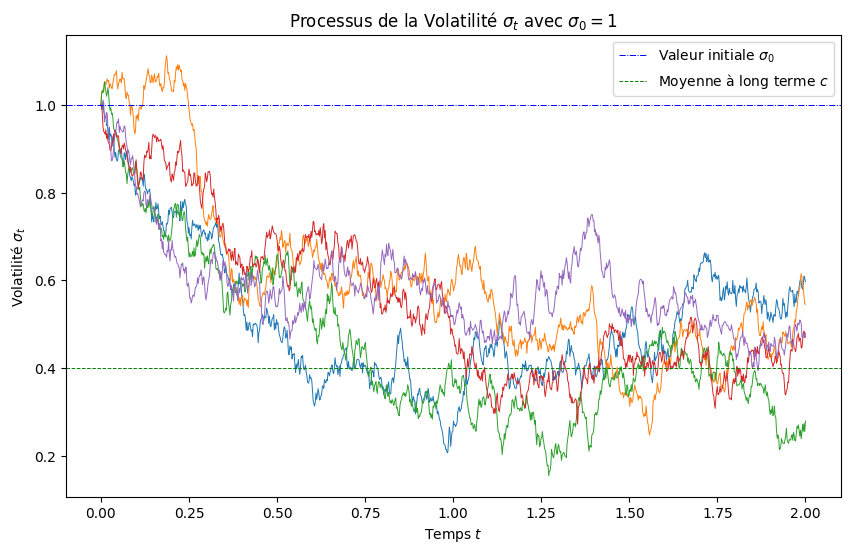

In [4]:
# Simulation des trajectoires avec sig0 = 1
sig_traject = sigma(c, sig0, lamda, gamma, T, n, m)

# Affichage de 10 trajectoires de sigma
times = np.linspace(0, T, n)
plt.figure(figsize=(10, 6), dpi=100)
for i in range(5):
    plt.plot(times, sig_traject[i], linewidth=0.7)

# Lignes de référence pour sigma_0 et la moyenne à long terme c
plt.xlabel('Temps $t$')
plt.ylabel('Volatilité $\sigma_t$')
plt.axhline(sig0, color='blue', linewidth=0.7, linestyle='-.', label="Valeur initiale $\sigma_0$")
plt.axhline(c, color='green', linewidth=0.7, linestyle='--', label="Moyenne à long terme $c$")
plt.legend()
plt.title('Processus de la Volatilité $\sigma_t$ avec $\sigma_0 = 1$')
plt.show()

La dynamique est cohérente, la volatilité d'Ornstein-Uhlenbeck a tendance à faire un retour vers la moyenne c

### Question 2

on a: 
$$ S_t := S_0 e^{ -\frac{1}{2} \int_0^t \sigma_u^2 \, du + \int_0^t \sigma_u \, dW_u^1 } $$


In [ ]:
def prix_t(S0, c, sig0, lamda, gamma, T, n , m = 1000,  sigma_traj=None):
    """"
    """
    dt = T/n
    dW1 = np.sqrt(dt)*np.random.normal(0,1, (m, n-1))
    S_traj = np.zeros((n, m)) # Matrixe pour stocker les differents traj du prix

    S_traj[:, 0 ] = S0 
    if sigma_traj is None:
        sigma_traj = sigma(c, sig0, lamda, gamma, T, n, m) # Simuulation de sigma pour le calccule du prix
    
    int_term1 = np.cumsum(sigma_traj[:, :-1]**2*dt, axis=1)
    int_term2 = np.cumsum(sigma_traj[:, :-1]*dW1, axis=1)
    S_traj[:, 1:] = S0*np.exp(-0.5*int_term1 + int_term2)

    return S_traj

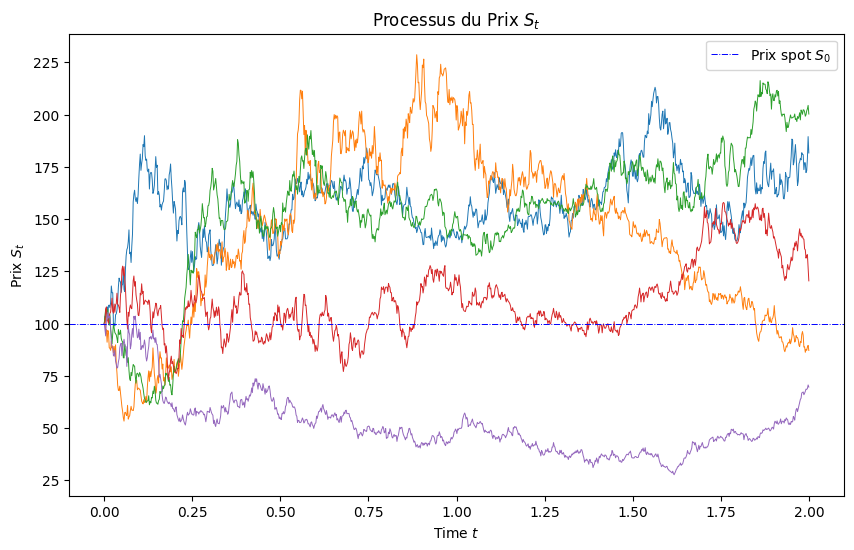

In [6]:
# Simulation des trajectoires de prix
S0= 100

S_t = prix_t(S0, c, sig0, lamda, gamma, T, n, m = 1000, sigma_traj= sig_traject)

# Affichage de 10 trajectoires de S_t
times = np.linspace(0, T, n)
plt.figure(figsize=(10, 6), dpi=100)
for i in range(5):
    plt.plot(times, S_t[i], linewidth=0.7)

plt.xlabel('Time $t$')
plt.ylabel('Prix $S_t$')
plt.title('Processus du Prix $S_t$')
plt.axhline(S0, times.min(), times.max(), c='blue', linewidth=.7, linestyle='-.', label="Prix spot $S_0$")
plt.legend()

Les trajectoires de $S_t$ montrent la dynamique d'un actif risqué avec volatilité stochastique. En fonction des fluctuations de $\sigma_t$ les trajectoire du prix montrent des variation de volatité

### Question 3

On a: 
$$
P_{L_T}(\Sigma) = \frac{1}{2} \int_0^T e^{r(T - u)} \left( \Sigma^2 - \sigma_u^2 \right) S_u^2 \Gamma^{BS}(u, S_u, \Sigma) \, du

$$

Avec: 

$ \Gamma^{BS}(t, s, \Sigma) = \frac{\partial^2}{\partial s^2} BS(t, s, \Sigma) = \frac{N'(d_+) e^{-r(T-t)}}{S \Sigma \sqrt{T-t}}, \quad \text{where } N'(d_+) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2d_+^2}}.
$


In [7]:
def dplus(s,k,v):
    # Cette fonction calcul d+
    epsilon = 1e-10
    v = np.maximum(v, epsilon)
    return np.log(s/k)/np.sqrt(v) + np.sqrt(v)/2

def Gamma_BS(t, S0, sigm, K, r, T):
    # Fonction gamma de Black Sholes
    epsilon = 1e-10
    Kr = K*np.exp(-r*(T-t))
    v = sigm**2*(T-t)
    d = dplus(S0, Kr, v)

    return stats.norm.pdf(d)/(S0*sigm*np.sqrt(np.maximum(T - t, epsilon)))


def PL(sigm, r, K, S0, sig0, c, lamda, gamma, T, n, m=1000):

    dt = T/n

    times =  np.linspace(0, T, n)

    # Calculons les traj de sigma
    sigma_traj = sigma(c, sig0, lamda, gamma, T, n, m)
    # Trajectoires des prix
    S = prix_t(S0, c, sig0, lamda, gamma, T, n , m = 1000,  sigma_traj = sigma_traj)

    # Calcul de Gamma_BS
    Gamma_BS_values = Gamma_BS(times[:, None], S, sigm, K, r, T)

    # integrande
    integrand = 0.5 * np.exp(r*(T - times[:, None])) * (sigm**2 - sigma_traj**2) * S**2 * Gamma_BS_values
    
    PLT = np.cumsum(integrand*dt, axis = 0)[-1, :]
    return PLT
    

Text(0.5, 1.0, 'Moyenne et variance de $PLT$ en fonction de $K$')

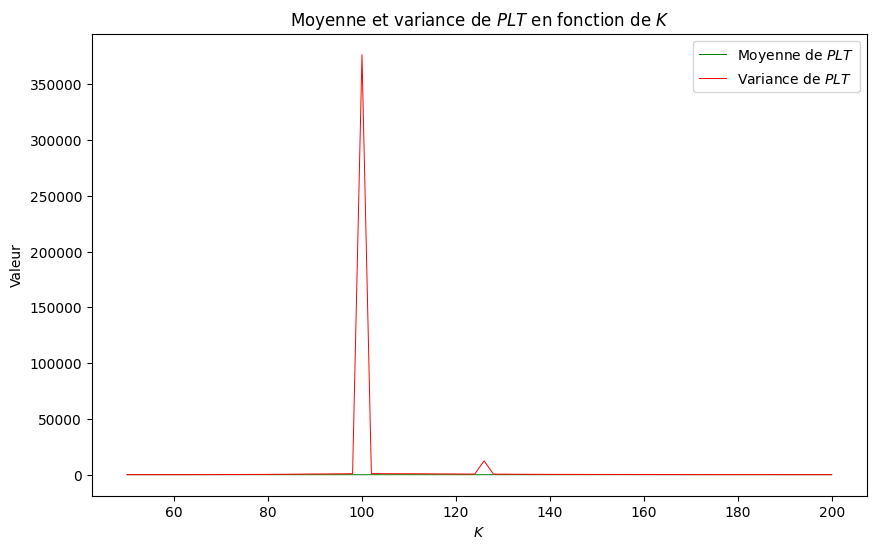

In [8]:
# Prix d'exercice K variant de 50 à 200
K_values = np.arange(50, 201, 2)
sigma0 = 0.2

means = []
variances = []

# Simulation de P_{L_T}(\Sigma) pour chaque K
for K in K_values:
    PLT_values = PL(sigma0 , r, K, S0, sig0, c, lamda, gamma, T, n, m)
    means.append(np.mean(PLT_values))
    variances.append(np.var(PLT_values))


# Affichage de la moyenne et variance de PLT
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(K_values, means, linewidth=0.7, label="Moyenne de $PLT$", color='green')
plt.plot(K_values, variances, linewidth=0.7, label="Variance de $PLT$", color='red')
plt.xlabel('$K$')
plt.ylabel('Valeur')
plt.legend()
plt.title("Moyenne et variance de $PLT$ en fonction de $K$")


Text(0, 0.5, 'Densité')

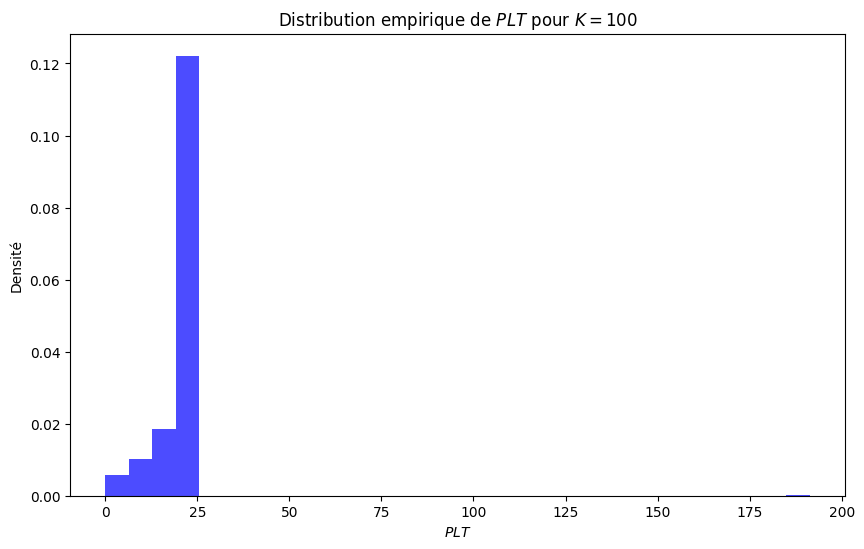

In [9]:
# distribution empirique de PLT

K = 100
PLT_K = PL(sig0, r, K, S0, sig0, c, lamda, gamma, T, n, m)
plt.figure(figsize=(10, 6), dpi=100)
plt.hist(PLT_K, bins=30, density=True, alpha=0.7, color='blue')
plt.title(f'Distribution empirique de $PLT$ pour $K = 100$')
plt.xlabel('$PLT$')
plt.ylabel('Densité')

La distribution empirique de $ PL_T(\Sigma) $ montre une asymétrie en fonction des valeurs de 𝐾, 

